This notebook will be used for the IBM Applied Data Science Capstone project

I will attempt to develop a model to predict the median property value for a neighborhood in Inner London based on factors such as distance to central London, number of schools, doctors offices, parks, transport links such as train stations. 

First, need to find and scrape list of suburbs of London and find location coordinates using google or nominatim

The London authorities make a massive amount of data available about the demographics of London areas so my first step is to find a dataset which includes a standard description of a Borough, Ward or Postal Area which can be used to generate foursquare data and for which demographic data is available such as median house prices.

Complete postcode is too fine a distinction as there are approx 322,000 individual postcodes in Greater London while there are 276 postcode 'outcodes'. 

In [3]:
import pandas as pd
import numpy as np


Borough is too large as there are only 32 Boroughs (+ City of London) of which 12 are considered 'Inner London'. There are 627 Wards in Greater London which is too large a data sample.

In [4]:
url = "https://en.wikipedia.org/wiki/List_of_London_boroughs"

dfs = pd.read_html(url)
df = dfs[0] #extract the first table from the wikipedia page
df

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,Croydon,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
7,Ealing,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
8,Enfield,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30
9,Greenwich [note 2],[note 3],Royal,Greenwich London Borough Council,Labour,"Woolwich Town Hall, Wellington Street",18.28,264008,51°29′21″N 0°03′53″E﻿ / ﻿51.4892°N 0.0648°E,22


There are 221 Wards in the 12 Boroughs considered 'Inner' London which looks like a reasonable level of granularity which should give enough data points to draw conclusions. 

There is a lot of demographic and socioeconomic data available from data.london.gov.uk which I propose to use as the basis for this project. The main file I will use is the ward profiles data which dates back to 2011 and so does not map perfectly to the wards in the Boroughs of Hackney, Tower Hamlets and Kensington and Chelsea which were changed in 2014.

In [5]:
url = "https://data.london.gov.uk/download/ward-profiles-and-atlas/a187b63e-bf4f-4449-b644-ab86a0a8569d/ward-profiles-excel-version.xls"

dfs = pd.read_excel(url, "Data")
dfs.head()

,Ward name,Old code,New code,Population - 2015,Children aged 0-15 - 2015,Working-age (16-64) - 2015,Older people aged 65+ - 2015,% All Children aged 0-15 - 2015,% All Working-age (16-64) - 2015,% All Older people aged 65+ - 2015,...,A-Level Average Point Score Per Student - 2013/14,A-Level Average Point Score Per Entry; 2013/14,Crime rate - 2014/15,Violence against the person rate - 2014/15,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Cars per household - 2011,Average Public Transport Accessibility score - 2014,% travel by bicycle to work - 2011,Turnout at Mayoral election - 2012
0,City of London,00AA,E09000001,8100,650,6250,1250,7.96206,76.8868,15.1512,...,662.9,210.5,656.381,85.3086,0.392259,18.629,0.385861,7.8623,5.30862,48.5237
1,Barking and Dagenham - Abbey,00ABFX,E05000026,14750,3850,10150,750,25.9583,69.0142,5.02748,...,682.57,208.937,138.139,42.2373,1.35308,21.9086,0.547682,5.98936,0.801603,25.6889
2,Barking and Dagenham - Alibon,00ABFY,E05000027,10600,2700,6800,1050,25.7013,64.2769,10.0217,...,627.928,201.599,73.5898,27.2642,0.653778,20.6218,0.81516,3.14589,1.02041,20.3479
3,Barking and Dagenham - Becontree,00ABFZ,E05000028,12700,3200,8350,1100,25.3704,65.9127,8.7169,...,631.958,207.901,79.9041,27.6378,1.18963,1.88545,0.870236,2.87177,1.64741,22.5382
4,Barking and Dagenham - Chadwell Heath,00ABGA,E05000029,10400,2550,6400,1450,24.3269,61.5,14.1731,...,613.944,210.457,76.1252,24.6154,1.25144,55.9745,0.918062,2.26091,1.17467,25.3188


In [6]:
dfs_indexed = dfs.set_index("Ward name")

Create a dataframe containing a list of wards in Inner London and their co-ordinates

In [65]:
inner_bor = ["Camden", "Greenwich", "Hackney", "Hammersmith and Fulham", "Islington", "Kensington and Chelsea", "Lambeth", "Lewisham", "Southwark", "Tower Hamlets", "Wandsworth", "Westminster"]
wards = pd.DataFrame(columns = ["Ward"] )

for i in np.arange(625):
    for borough in inner_bor:
        if dfs.loc[i, "Ward name"][:len(borough)] == borough:
            wards.loc[i, "Ward"] = dfs.loc[i, "Ward name"]
            wards.loc[i, "Code"] = dfs.loc[i, "New code"]
            
wards.reset_index(drop = True, inplace=True)
wards

,Ward,Code
0,Camden - Belsize,E05000128
1,Camden - Bloomsbury,E05000129
2,Camden - Camden Town with Primrose Hill,E05000130
3,Camden - Cantelowes,E05000131
4,Camden - Fortune Green,E05000132
...,...,...
216,Westminster - Tachbrook,E05000645
217,Westminster - Vincent Square,E05000646
218,Westminster - Warwick,E05000647
219,Westminster - Westbourne,E05000648


The ONS (Office of National Statistics) website is a good source for a dataset which includes longitude and latitude for electoral wards in the UK so I will use this to identify the geo coordinates for the wards in London. I have downloaded the data from https://geoportal.statistics.gov.uk/datasets/wards-december-2017-full-clipped-boundaries-in-uk-wgs84/data

This dataset relates to Ward boundaries after 2014 and so does not perfectly align with the principal dataset that I am using. I will therefore manually adjust the references for Hackney, Tower Hamlets and Kensington and Chelsea wards to retain the wards that have not changed, at least in name.

I will use the reference code ('New Code' in the ward data spreadsheet and 'wd17cd' in the ONS data file) to map the ward co-ordinates to the ward name for the Inner London wards that I will be studying

In [29]:
path = r"C:\Users\dannz\Documents\Study\Coursera_Data_Science_Spec\Applied_Data_Science_Capstone\Coursera_Capstone\Wards__December_2017__Boundaries_in_the_UK__WGS84_.xlsx"

dfref = pd.read_excel(path)
dfref.head()

,objectid,wd17cd,wd17nm,wd17nmw,bng_e,bng_n,long,lat,st_areashape,st_lengthshape
0,1,E05000026,Abbey,,544434,184378,0.081291,51.539822,0.000163,0.095056
1,2,E05000027,Alibon,,549247,185196,0.150987,51.545921,0.000177,0.081044
2,3,E05000028,Becontree,,546863,185869,0.116912,51.552601,0.000167,0.075036
3,4,E05000029,Chadwell Heath,,548266,189340,0.138596,51.583420,0.000439,0.108753
4,5,E05000030,Eastbrook,,550774,186272,0.173453,51.555191,0.000447,0.106966


In [66]:
for i in np.arange(221):
    for j in np.arange(9131):
        if wards.loc[i, "Code"] == dfref.loc[j, "wd17cd"]:
            wards.loc[i, "Latitude"] = dfref.loc[j, "lat"]
            wards.loc[i, "Longitude"] = dfref.loc[j, "long"]

wards

,Ward,Code,Latitude,Longitude
0,Camden - Belsize,E05000128,51.546730,-0.16643
1,Camden - Bloomsbury,E05000129,51.521900,-0.13256
2,Camden - Camden Town with Primrose Hill,E05000130,51.540852,-0.14934
3,Camden - Cantelowes,E05000131,51.544868,-0.13389
4,Camden - Fortune Green,E05000132,51.553070,-0.20014
...,...,...,...,...
216,Westminster - Tachbrook,E05000645,51.488750,-0.13458
217,Westminster - Vincent Square,E05000646,51.492859,-0.13166
218,Westminster - Warwick,E05000647,51.492279,-0.14392
219,Westminster - Westbourne,E05000648,51.521099,-0.19106


In [67]:
wards.describe(include='all')

,Ward,Code,Latitude,Longitude
count,221,221,202.000000,202.000000
unique,221,221,NaN,NaN
top,Islington - Highbury East,E05000225,NaN,NaN
freq,1,1,NaN,NaN
mean,NaN,NaN,51.494219,-0.110537
std,NaN,NaN,0.039664,0.079420
min,NaN,NaN,51.417419,-0.243370
25%,NaN,NaN,51.464766,-0.174123
50%,NaN,NaN,51.490681,-0.119085
75%,NaN,NaN,51.526974,-0.063260


19 of the post-2014 wards do not map to pre-2014 wards so I propose to remove the wards which do not have a longitude and latitude

In [70]:
wards.dropna(inplace=True)
wards.reset_index(drop=True, inplace=True)
wards.describe(include="all")

,Ward,Code,Latitude,Longitude
count,202,202,202.000000,202.000000
unique,202,202,NaN,NaN
top,Islington - Highbury East,E05000225,NaN,NaN
freq,1,1,NaN,NaN
mean,NaN,NaN,51.494219,-0.110537
std,NaN,NaN,0.039664,0.079420
min,NaN,NaN,51.417419,-0.243370
25%,NaN,NaN,51.464766,-0.174123
50%,NaN,NaN,51.490681,-0.119085
75%,NaN,NaN,51.526974,-0.063260


I will now visualise the wards on a map of London

In [72]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

In [73]:
address = 'London, UK'

geolocator = Nominatim(user_agent="London_UK")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [74]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, ward in zip(wards['Latitude'], wards['Longitude'], wards['Ward']):
    label = '{}'.format(ward)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

I will now calculate the approximate distance of each ward's location from a point in Central London. The point used to centre the map above is suitable as it is the roundabout at Trafalgar Square, which is a good approxomation for Central London.

I will assume that the Earth is flat as over the small distances we are working the effect of the Earth's curvature should be negligable.

In [75]:
from math import cos

In [76]:
wards_dist = wards.copy()

In [80]:
for i in np.arange(202):
    latdist = (latitude - wards_dist.loc[i, 'Latitude'])*110.574
    longdist = (longitude - wards_dist.loc[i, 'Longitude'])*(111.320*(cos((wards_dist.loc[i, 'Longitude'])/180/(22/7))))
    wards_dist.loc[i, 'Distance'] = ((latdist**2)+(longdist**2))**0.5

In [81]:
wards_dist

,Ward,Code,Latitude,Longitude,Distance
0,Camden - Belsize,E05000128,51.546730,-0.16643,6.134072
1,Camden - Bloomsbury,E05000129,51.521900,-0.13256,1.702217
2,Camden - Camden Town with Primrose Hill,E05000130,51.540852,-0.14934,4.424591
3,Camden - Cantelowes,E05000131,51.544868,-0.13389,4.209433
4,Camden - Fortune Green,E05000132,51.553070,-0.20014,9.524280
...,...,...,...,...,...
197,Westminster - Tachbrook,E05000645,51.488750,-0.13458,2.193745
198,Westminster - Vincent Square,E05000646,51.492859,-0.13166,1.660443
199,Westminster - Warwick,E05000647,51.492279,-0.14392,2.459296
200,Westminster - Westbourne,E05000648,51.521099,-0.19106,7.221601


The next step is to collect foursquare data showing the number of venues of the types which we are interested in within a certain radius of each ward. This will hopefully allow some meaningful comparison between wards. First I will take a look at the total number of venues Foursquare is aware of in the wards.

In [82]:
CLIENT_ID = 'OFN3EGYURQ43GXRGR4ZP5GUCFIWMZJBE0JZRSFKJEKTEPEPR' # your Foursquare ID
CLIENT_SECRET = 'KAY1HVE1ADVA04PWQLTX5GHX5PVXLCKN5TKZKMECQWRH5DGX' # your Foursquare Secret
VERSION = '20181001' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OFN3EGYURQ43GXRGR4ZP5GUCFIWMZJBE0JZRSFKJEKTEPEPR
CLIENT_SECRET:KAY1HVE1ADVA04PWQLTX5GHX5PVXLCKN5TKZKMECQWRH5DGX


In [83]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
LIMIT = 200
london_venues = getNearbyVenues(names=wards['Ward'],
                                   latitudes=wards['Latitude'],
                                   longitudes=wards['Longitude'], radius='500')

In [17]:
london_venues.describe(include='all')

,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
count,6509,6509.000000,6509.000000,6509,6509.000000,6509.000000,6509
unique,202,NaN,NaN,4811,NaN,NaN,357
top,Southwark - Cathedrals,NaN,NaN,Sainsbury's Local,NaN,NaN,Pub
freq,100,NaN,NaN,50,NaN,NaN,510
mean,NaN,51.504543,-0.134456,NaN,51.504448,-0.134516,NaN
std,NaN,0.032316,0.059666,NaN,0.032354,0.059522,NaN
min,NaN,51.417419,-0.243370,NaN,51.415382,-0.248737,NaN
25%,NaN,51.486118,-0.184840,NaN,51.485743,-0.185896,NaN
50%,NaN,51.504639,-0.134580,NaN,51.505199,-0.137733,NaN
75%,NaN,51.526981,-0.094560,NaN,51.526196,-0.094246,NaN


There are 6509 venues from 357 unique categories. I will now look to see which are the most common 10 types of venue in each ward

In [18]:
london_common = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add ward column back to dataframe
london_common['Ward'] = london_venues['Ward'] 

# move ward column to the first column
fixed_columns = [london_common.columns[-1]] + list(london_common.columns[:-1])
london_common = london_common[fixed_columns]

london_common

,Ward,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Camden - Belsize,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Camden - Belsize,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Camden - Belsize,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Camden - Belsize,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Camden - Belsize,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6504,Westminster - West End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6505,Westminster - West End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6506,Westminster - West End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6507,Westminster - West End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
london_grouped = london_common.groupby('Ward').sum().reset_index()
london_grouped

,Ward,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Camden - Belsize,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,Camden - Bloomsbury,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,Camden - Camden Town with Primrose Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,Camden - Cantelowes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Camden - Fortune Green,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,Westminster - Tachbrook,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,Westminster - Vincent Square,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199,Westminster - Warwick,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
200,Westminster - West End,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,2,0,0


In [20]:
num_top_venues = 10

for hood in london_grouped['Ward']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Ward'] == hood].T.reset_index()
    temp.columns = ['venue','count']
    temp = temp.iloc[1:]
    temp['count'] = temp['count'].astype(int)
    print(temp.sort_values('count', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Camden - Belsize----
                venue  count
0                Café      7
1   Convenience Store      4
2              Bakery      3
3         Coffee Shop      3
4  Italian Restaurant      3
5               Hotel      2
6                 Pub      2
7            Bus Stop      2
8       Deli / Bodega      2
9   Indian Restaurant      2


----Camden - Bloomsbury----
                 venue  count
0          Coffee Shop     11
1              Exhibit      5
2                  Bar      3
3          Pizza Place      3
4    French Restaurant      2
5  Japanese Restaurant      2
6                 Park      2
7            Bookstore      2
8   Italian Restaurant      2
9               Bistro      1


----Camden - Camden Town with Primrose Hill----
                           venue  count
0                           Café      5
1                            Pub      5
2                    Coffee Shop      4
3                            Bar      4
4                         Market      3
5  Veg

9                   Pharmacy      0


----Greenwich - Woolwich Riverside----
                   venue  count
0            Music Store      1
1          Train Station      1
2                   Café      1
3   Fast Food Restaurant      1
4  Performing Arts Venue      0
5     Physical Therapist      0
6     Photography Studio      0
7               Pharmacy      0
8              Pet Store      0
9    Peruvian Restaurant      0


----Hackney - Brownswood----
                venue  count
0                Café      5
1                 Pub      3
2         Pizza Place      2
3               Hotel      2
4         Coffee Shop      2
5       Grocery Store      2
6   Fish & Chips Shop      1
7        Climbing Gym      1
8  Chinese Restaurant      1
9  Turkish Restaurant      1


----Hackney - Cazenove----
                venue  count
0                 Pub      2
1        Tennis Court      1
2       Deli / Bodega      1
3                Café      1
4                Park      1
5                 

                       venue  count
0                        Pub      3
1                       Café      2
2                  Gastropub      2
3          Fish & Chips Shop      1
4  Middle Eastern Restaurant      1
5                      Trail      1
6              Deli / Bodega      1
7         Italian Restaurant      1
8        Japanese Restaurant      1
9  Latin American Restaurant      1


----Islington - Clerkenwell----
                venue  count
0                 Pub      6
1         Coffee Shop      5
2                Café      3
3        Cocktail Bar      3
4         Pizza Place      3
5                 Bar      3
6  Italian Restaurant      2
7                Park      2
8              Bakery      2
9   French Restaurant      2


----Islington - Finsbury Park----
                     venue  count
0                     Café      4
1            Grocery Store      3
2                      Pub      3
3     Gym / Fitness Center      3
4           Sandwich Place      1
5         S

                   venue  count
0      Convenience Store      4
1  Portuguese Restaurant      4
2          Grocery Store      3
3                    Pub      3
4                   Park      2
5            Coffee Shop      2
6                 Bakery      2
7            Supermarket      2
8              Gastropub      1
9               Pharmacy      1


----Lambeth - Streatham Hill----
                  venue  count
0         Grocery Store      3
1           Coffee Shop      3
2              Bus Stop      2
3  Fast Food Restaurant      2
4           Pizza Place      2
5                  Café      1
6                  Park      1
7      Tapas Restaurant      1
8            Beer Store      1
9            Restaurant      1


----Lambeth - Streatham South----
              venue  count
0               Pub      2
1          Platform      2
2      Burger Joint      1
3         Gastropub      1
4       Supermarket      1
5       Pizza Place      1
6  Video Game Store      1
7  Pedestrian Plaza 

                    venue  count
0                    Café      3
1          Clothing Store      3
2                     Bar      2
3             Pizza Place      2
4                Platform      2
5                Pharmacy      2
6             Coffee Shop      2
7           Train Station      2
8  Furniture / Home Store      1
9           Movie Theater      1


----Southwark - South Bermondsey----
                   venue  count
0          Grocery Store      2
1               Bus Stop      1
2                    Pub      1
3               Pharmacy      1
4            Pizza Place      1
5                  Plaza      1
6                   Park      1
7  Vietnamese Restaurant      1
8                   Café      1
9   Pakistani Restaurant      0


----Southwark - South Camberwell----
            venue  count
0             Pub      3
1     Coffee Shop      2
2             ATM      1
3          Bakery      1
4     Pizza Place      1
5     Auto Garage      1
6  Soccer Stadium      1
7      

----Westminster - Church Street----
                venue  count
0                Café      2
1               Hotel      2
2      Sandwich Place      2
3         Yoga Studio      1
4               Plaza      1
5         Bus Station      1
6               Canal      1
7          Sports Bar      1
8         Coffee Shop      1
9  Falafel Restaurant      1


----Westminster - Churchill----
                venue  count
0  Italian Restaurant      5
1                 Pub      4
2               Hotel      3
3                Café      2
4              Bakery      2
5              Garden      2
6         Social Club      1
7      Ice Cream Shop      1
8                 Bar      1
9     Thai Restaurant      1


----Westminster - Harrow Road----
                       venue  count
0              Grocery Store      3
1                Coffee Shop      3
2        Lebanese Restaurant      2
3                Pizza Place      2
4                      Hotel      2
5          Indian Restaurant      2
6   

Now we will look at the number of venues within 500m of each ward which may have an influence on the median property value. I will look at the number of parks, doctor's offices, schools and train stations.

The category codes can be found here https://developer.foursquare.com/docs/build-with-foursquare/categories/

In [84]:
wards_indx=wards.set_index("Ward")

In [85]:
#import visualisation and analysis tools
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline 

In [86]:
def SearchVenues(names, latitudes, longitudes, category, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        try:
            for result in results:
                venues_list.append([
                name, 
                lat, 
                lng,
                result['name'], 
                result['location']['lat'], 
                result['location']['lng'],
                result['categories'][0]['name']])
        except:
            continue

    column_names = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Category']
    nearby_venues = pd.DataFrame(venues_list, columns=column_names)
    
    return(nearby_venues)

First we will collect the data for the number of parks

In [199]:
LIMIT = 200
london_venues_park = SearchVenues(names=wards['Ward'],
                                   latitudes=wards['Latitude'],
                                   longitudes=wards['Longitude'],
                                   category='4bf58dd8d48988d163941735',
                                   radius=500)

In [200]:
london_venues_park

,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Category
0,Camden - Bloomsbury,51.521900,-0.13256,Gordon Square,51.524098,-0.130763,Park
1,Camden - Bloomsbury,51.521900,-0.13256,Torrington Sq,51.522546,-0.130154,Park
2,Camden - Bloomsbury,51.521900,-0.13256,Whitfield Gardens,51.521087,-0.135016,Park
3,Camden - Bloomsbury,51.521900,-0.13256,Woburn Square,51.523257,-0.129615,Park
4,Camden - Bloomsbury,51.521900,-0.13256,Tavistock Square,51.525006,-0.129068,Park
...,...,...,...,...,...,...,...
604,Westminster - Westbourne,51.521099,-0.19106,Edbrooke Road Gardens,51.523349,-0.195370,Park
605,Westminster - West End,51.511341,-0.14543,Hanover Square,51.513913,-0.143808,Park
606,Westminster - West End,51.511341,-0.14543,Grosvenor Square,51.511467,-0.151448,Park
607,Westminster - West End,51.511341,-0.14543,Mount Street Gardens,51.509143,-0.150203,Park


In [201]:
ldn_park_grouped=london_venues_park.groupby('Ward').count().reset_index()

In [202]:
ldn_park_grouped.drop(columns=["Ward Latitude", "Ward Longitude", "Venue Latitude", "Venue Longitude", "Category"],inplace = True)
ldn_park_grouped.rename(columns={"Venue" : "Count"},inplace = True)

In [203]:
ldn_park_grouped.set_index('Ward', drop = False, inplace=True)

In [204]:
ldn_park_grouped

,Ward,Count
Ward,,
Camden - Bloomsbury,Camden - Bloomsbury,13
Camden - Camden Town with Primrose Hill,Camden - Camden Town with Primrose Hill,6
Camden - Cantelowes,Camden - Cantelowes,2
Camden - Fortune Green,Camden - Fortune Green,2
Camden - Gospel Oak,Camden - Gospel Oak,1
...,...,...
Westminster - Tachbrook,Westminster - Tachbrook,5
Westminster - Vincent Square,Westminster - Vincent Square,7
Westminster - Warwick,Westminster - Warwick,4


In [205]:
for i in np.arange(202):
    if wards_dist.loc[i,'Ward'] in list(ldn_park_grouped.index):
        wards_dist.loc[i,'Parks Count'] = ldn_park_grouped.loc[wards_dist.loc[i,'Ward'],'Count']
    else:
        wards_dist.loc[i,'Parks Count'] = 0

In [206]:
wards_dist

,Ward,Code,Latitude,Longitude,Distance,Parks Count,Doctors Count,Schools Count,Station Count,House Price
0,Camden - Belsize,E05000128,51.546730,-0.16643,6.134072,0.0,2.0,4.0,3.0,850000.0
1,Camden - Bloomsbury,E05000129,51.521900,-0.13256,1.702217,13.0,10.0,21.0,5.0,560000.0
2,Camden - Camden Town with Primrose Hill,E05000130,51.540852,-0.14934,4.424591,6.0,3.0,9.0,2.0,813500.0
3,Camden - Cantelowes,E05000131,51.544868,-0.13389,4.209433,2.0,3.0,7.0,0.0,560000.0
4,Camden - Fortune Green,E05000132,51.553070,-0.20014,9.524280,2.0,3.0,4.0,0.0,575000.0
...,...,...,...,...,...,...,...,...,...,...
197,Westminster - Tachbrook,E05000645,51.488750,-0.13458,2.193745,5.0,2.0,10.0,1.0,715650.0
198,Westminster - Vincent Square,E05000646,51.492859,-0.13166,1.660443,7.0,3.0,11.0,1.0,840000.0
199,Westminster - Warwick,E05000647,51.492279,-0.14392,2.459296,4.0,4.0,9.0,1.0,857250.0
200,Westminster - Westbourne,E05000648,51.521099,-0.19106,7.221601,3.0,4.0,4.0,2.0,499975.0


Next, I will add the number of doctor's offices

In [162]:
LIMIT = 200
london_docs = SearchVenues(names=wards['Ward'],
                            latitudes=wards['Latitude'],
                            longitudes=wards['Longitude'],
                            category='4bf58dd8d48988d177941735',
                            radius=500)

In [163]:
ldn_doc_grouped=london_docs.groupby('Ward').count().reset_index()

In [164]:
ldn_doc_grouped.drop(columns=["Ward Latitude", "Ward Longitude", "Venue Latitude", "Venue Longitude", "Category"],inplace = True)
ldn_doc_grouped.rename(columns={"Venue" : "Count"},inplace = True)
ldn_doc_grouped.set_index('Ward', drop = False, inplace=True)
ldn_doc_grouped

,Ward,Count
Ward,,
Camden - Belsize,Camden - Belsize,2
Camden - Bloomsbury,Camden - Bloomsbury,10
Camden - Camden Town with Primrose Hill,Camden - Camden Town with Primrose Hill,3
Camden - Cantelowes,Camden - Cantelowes,3
Camden - Fortune Green,Camden - Fortune Green,3
...,...,...
Westminster - Tachbrook,Westminster - Tachbrook,2
Westminster - Vincent Square,Westminster - Vincent Square,3
Westminster - Warwick,Westminster - Warwick,4


In [165]:
for i in np.arange(202):
    if wards_dist.loc[i,'Ward'] in list(ldn_doc_grouped.index):
        wards_dist.loc[i,'Doctors Count'] = ldn_doc_grouped.loc[wards_dist.loc[i,'Ward'],'Count']
    else:
        wards_dist.loc[i,'Doctors Count'] = 0

In [166]:
wards_dist

,Ward,Code,Latitude,Longitude,Distance,Parks Count,Doctors Count
0,Camden - Belsize,E05000128,51.546730,-0.16643,6.134072,0.0,2.0
1,Camden - Bloomsbury,E05000129,51.521900,-0.13256,1.702217,13.0,10.0
2,Camden - Camden Town with Primrose Hill,E05000130,51.540852,-0.14934,4.424591,6.0,3.0
3,Camden - Cantelowes,E05000131,51.544868,-0.13389,4.209433,2.0,3.0
4,Camden - Fortune Green,E05000132,51.553070,-0.20014,9.524280,2.0,3.0
...,...,...,...,...,...,...,...
197,Westminster - Tachbrook,E05000645,51.488750,-0.13458,2.193745,5.0,2.0
198,Westminster - Vincent Square,E05000646,51.492859,-0.13166,1.660443,7.0,3.0
199,Westminster - Warwick,E05000647,51.492279,-0.14392,2.459296,4.0,4.0
200,Westminster - Westbourne,E05000648,51.521099,-0.19106,7.221601,3.0,4.0


Next the number of schools, I have taken the general school category

In [167]:
LIMIT = 200
london_sch = SearchVenues(names=wards['Ward'],
                            latitudes=wards['Latitude'],
                            longitudes=wards['Longitude'],
                            category='4bf58dd8d48988d13b941735',
                            radius=500)

In [168]:
ldn_sch_grouped=london_sch.groupby('Ward').count().reset_index()

In [169]:
ldn_sch_grouped.drop(columns=["Ward Latitude", "Ward Longitude", "Venue Latitude", "Venue Longitude", "Category"],inplace = True)
ldn_sch_grouped.rename(columns={"Venue" : "Count"},inplace = True)
ldn_sch_grouped.set_index('Ward', drop = False, inplace=True)
ldn_sch_grouped

,Ward,Count
Ward,,
Camden - Belsize,Camden - Belsize,4
Camden - Bloomsbury,Camden - Bloomsbury,21
Camden - Camden Town with Primrose Hill,Camden - Camden Town with Primrose Hill,9
Camden - Cantelowes,Camden - Cantelowes,7
Camden - Fortune Green,Camden - Fortune Green,4
...,...,...
Westminster - Tachbrook,Westminster - Tachbrook,10
Westminster - Vincent Square,Westminster - Vincent Square,11
Westminster - Warwick,Westminster - Warwick,9


In [170]:
for i in np.arange(202):
    if wards_dist.loc[i,'Ward'] in list(ldn_sch_grouped.index):
        wards_dist.loc[i,'Schools Count'] = ldn_sch_grouped.loc[wards_dist.loc[i,'Ward'],'Count']
    else:
        wards_dist.loc[i,'Schools Count'] = 0

In [171]:
wards_dist

,Ward,Code,Latitude,Longitude,Distance,Parks Count,Doctors Count,Schools Count
0,Camden - Belsize,E05000128,51.546730,-0.16643,6.134072,0.0,2.0,4.0
1,Camden - Bloomsbury,E05000129,51.521900,-0.13256,1.702217,13.0,10.0,21.0
2,Camden - Camden Town with Primrose Hill,E05000130,51.540852,-0.14934,4.424591,6.0,3.0,9.0
3,Camden - Cantelowes,E05000131,51.544868,-0.13389,4.209433,2.0,3.0,7.0
4,Camden - Fortune Green,E05000132,51.553070,-0.20014,9.524280,2.0,3.0,4.0
...,...,...,...,...,...,...,...,...
197,Westminster - Tachbrook,E05000645,51.488750,-0.13458,2.193745,5.0,2.0,10.0
198,Westminster - Vincent Square,E05000646,51.492859,-0.13166,1.660443,7.0,3.0,11.0
199,Westminster - Warwick,E05000647,51.492279,-0.14392,2.459296,4.0,4.0,9.0
200,Westminster - Westbourne,E05000648,51.521099,-0.19106,7.221601,3.0,4.0,4.0


Next I will add the number of train stations

In [213]:
LIMIT = 200
london_trn = SearchVenues(names=wards['Ward'],
                            latitudes=wards['Latitude'],
                            longitudes=wards['Longitude'],
                            category='4bf58dd8d48988d129951735',
                            radius=500)

In [214]:
ldn_trn_grouped=london_trn.groupby('Ward').count().reset_index()

In [215]:
ldn_trn_grouped.drop(columns=["Ward Latitude", "Ward Longitude", "Venue Latitude", "Venue Longitude", "Category"],inplace = True)
ldn_trn_grouped.rename(columns={"Venue" : "Count"},inplace = True)
ldn_trn_grouped.set_index('Ward', drop = False, inplace=True)
ldn_trn_grouped

,Ward,Count
Ward,,
Camden - Bloomsbury,Camden - Bloomsbury,7
Camden - Camden Town with Primrose Hill,Camden - Camden Town with Primrose Hill,2
Camden - Cantelowes,Camden - Cantelowes,3
Camden - Gospel Oak,Camden - Gospel Oak,4
Camden - Haverstock,Camden - Haverstock,3
...,...,...
Westminster - Lancaster Gate,Westminster - Lancaster Gate,13
Westminster - St. James's,Westminster - St. James's,2
Westminster - Warwick,Westminster - Warwick,26


In [216]:
for i in np.arange(202):
    if wards_dist.loc[i,'Ward'] in list(ldn_trn_grouped.index):
        wards_dist.loc[i,'Station Count'] = ldn_trn_grouped.loc[wards_dist.loc[i,'Ward'],'Count']
    else:
        wards_dist.loc[i,'Station Count'] = 0

In [217]:
wards_dist

,Ward,Code,Latitude,Longitude,Distance,Parks Count,Doctors Count,Schools Count,Station Count,House Price
0,Camden - Belsize,E05000128,51.546730,-0.16643,6.134072,0.0,2.0,4.0,0.0,850000.0
1,Camden - Bloomsbury,E05000129,51.521900,-0.13256,1.702217,13.0,10.0,21.0,7.0,560000.0
2,Camden - Camden Town with Primrose Hill,E05000130,51.540852,-0.14934,4.424591,6.0,3.0,9.0,2.0,813500.0
3,Camden - Cantelowes,E05000131,51.544868,-0.13389,4.209433,2.0,3.0,7.0,3.0,560000.0
4,Camden - Fortune Green,E05000132,51.553070,-0.20014,9.524280,2.0,3.0,4.0,0.0,575000.0
...,...,...,...,...,...,...,...,...,...,...
197,Westminster - Tachbrook,E05000645,51.488750,-0.13458,2.193745,5.0,2.0,10.0,0.0,715650.0
198,Westminster - Vincent Square,E05000646,51.492859,-0.13166,1.660443,7.0,3.0,11.0,0.0,840000.0
199,Westminster - Warwick,E05000647,51.492279,-0.14392,2.459296,4.0,4.0,9.0,26.0,857250.0
200,Westminster - Westbourne,E05000648,51.521099,-0.19106,7.221601,3.0,4.0,4.0,1.0,499975.0


Now I will add our output to the DataFrame, that is the median property value

In [177]:
for i in np.arange(202):
    wards_dist.loc[i, "House Price"] = dfs_indexed.loc[wards_dist.loc[i, "Ward"], "Median House Price (£) - 2014"]

In [178]:
wards_dist

,Ward,Code,Latitude,Longitude,Distance,Parks Count,Doctors Count,Schools Count,Station Count,House Price
0,Camden - Belsize,E05000128,51.546730,-0.16643,6.134072,0.0,2.0,4.0,0.0,850000.0
1,Camden - Bloomsbury,E05000129,51.521900,-0.13256,1.702217,13.0,10.0,21.0,7.0,560000.0
2,Camden - Camden Town with Primrose Hill,E05000130,51.540852,-0.14934,4.424591,6.0,3.0,9.0,2.0,813500.0
3,Camden - Cantelowes,E05000131,51.544868,-0.13389,4.209433,2.0,3.0,7.0,3.0,560000.0
4,Camden - Fortune Green,E05000132,51.553070,-0.20014,9.524280,2.0,3.0,4.0,0.0,575000.0
...,...,...,...,...,...,...,...,...,...,...
197,Westminster - Tachbrook,E05000645,51.488750,-0.13458,2.193745,5.0,2.0,10.0,0.0,715650.0
198,Westminster - Vincent Square,E05000646,51.492859,-0.13166,1.660443,7.0,3.0,11.0,0.0,840000.0
199,Westminster - Warwick,E05000647,51.492279,-0.14392,2.459296,4.0,4.0,9.0,26.0,857250.0
200,Westminster - Westbourne,E05000648,51.521099,-0.19106,7.221601,3.0,4.0,4.0,1.0,499975.0


I will now visualise the relationship between each of the potential inputs to see if there is an obvious correlation

(0.0, 3677128.1240185876)

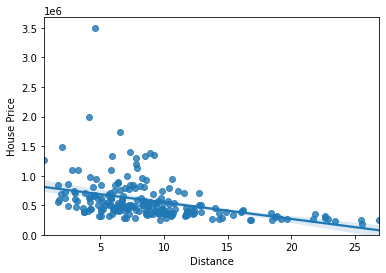

In [179]:
sns.regplot(x="Distance", y="House Price", data=wards_dist)
plt.ylim(0,)

In [180]:
wards_dist[["Distance", "House Price"]].corr()

,Distance,House Price
Distance,1.000000,-0.387057
House Price,-0.387057,1.000000


(0.0, 3665500.0)

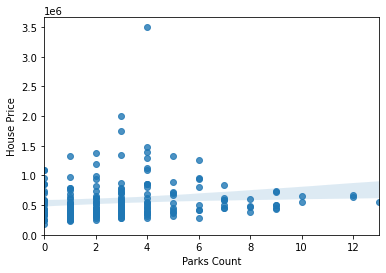

In [181]:
sns.regplot(x="Parks Count", y="House Price", data=wards_dist)
plt.ylim(0,)

(0.0, 3665500.0)

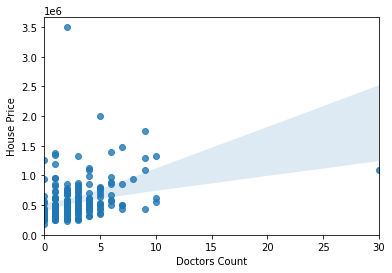

In [182]:
sns.regplot(x="Doctors Count", y="House Price", data=wards_dist)
plt.ylim(0,)

(0.0, 3665500.0)

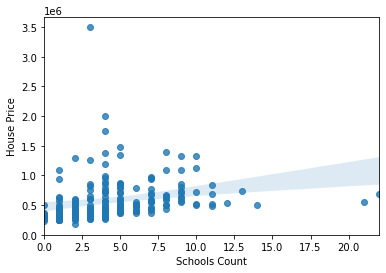

In [183]:
sns.regplot(x="Schools Count", y="House Price", data=wards_dist)
plt.ylim(0,)

(0.0, 3665500.0)

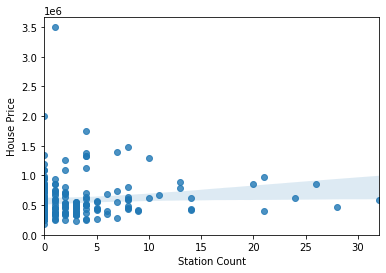

In [218]:
sns.regplot(x="Station Count", y="House Price", data=wards_dist)
plt.ylim(0,)

In [219]:
from scipy import stats

In [224]:
pearson_coef, p_value = stats.pearsonr(wards_dist['Distance'], wards_dist['House Price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is -0.3870570613758175  with a P-value of P = 1.2679250565841321e-08


In [226]:
pearson_coef, p_value = stats.pearsonr(wards_dist['Parks Count'], wards_dist['House Price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.12171144871859847  with a P-value of P = 0.08443191809261202


In [227]:
pearson_coef, p_value = stats.pearsonr(wards_dist['Doctors Count'], wards_dist['House Price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.31644336186755  with a P-value of P = 4.474083227600411e-06


In [228]:
pearson_coef, p_value = stats.pearsonr(wards_dist['Schools Count'], wards_dist['House Price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.23792404005421272  with a P-value of P = 0.0006504721198145261


In [230]:
pearson_coef, p_value = stats.pearsonr(wards_dist['Station Count'], wards_dist['House Price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.09719181898318424  with a P-value of P = 0.1688083792520249


Distance to Central London appears to have a weak relationship to house price however it i statistically significant. The number of doctor's offices also has a weak relationship to house price which is statistically significant. The number of schools has a very weak relationship to house price which is sttistically significant.

I suspect that a factor which influences house price is the time taken to travel to Central London which relates to distance and number of stations.